# Mask R-CNN - Train on Camus Dataset


This notebook shows how to perform transfer learning of Mask R-CNN models using echocardiogram images from the [Camus Project](https://www.creatis.insa-lyon.fr/Challenge/camus/) dataset. 

Authors: **Alex Carneiro** and **Luiz Tauffer**

## 1. Setup and data preparation

1. import the necessary Python modules 
2. Dowanload pre-trained model weights
3. preparing the data to be used by the Mask R-CNN model

In [1]:
%load_ext autoreload
%autoreload 2

# Imports and definition of constant paths
import os
import sys
from glob import glob
from tqdm import tqdm

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

import cv2
import skimage
import numpy as np

from camus_image_processing import fix_resolution, pre_filter

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

/home/tauffer/anaconda3/envs/env_tf1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/tauffer/anaconda3/envs/env_tf1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/tauffer/anaconda3/envs/env_tf1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/tauffer/anaconda3/envs/env_tf1/lib

In [2]:
def fix_resolution(image, side=128):
    """Adjust image resolution to a square shape without distortion"""
    f = 128 / np.max(image.shape)
    
    fixed_image = cv2.resize(image, None, fx=f, fy=f, interpolation=cv2.INTER_NEAREST)
    
    result_image = np.zeros((side, side))
    
    h, l = fixed_image.shape[:2]
    result_image[:h,:l] = fixed_image
    
    return result_image

def pre_filter(image):
    """Apply morphological filter"""
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, np.ones((3, 3)))

In [4]:
# The images are in data/ directory
#patients_path = glob("../../../../data/patient*/")
patients_path = glob("../../../../train/patient*/")

n_images = 0
for patient_path in tqdm(patients_path, ncols=80):
    masks_filenames = glob(patient_path + "*CH_*_gt.png")
    for mask_filename in masks_filenames:
        raw_filename = mask_filename.replace('_gt', '')
        
        try:
            image = cv2.imread(raw_filename).max(axis=2).astype(np.uint8)
            mask = cv2.imread(mask_filename).max(axis=2).astype(np.uint8)
            if image.shape != mask.shape:
                raise RuntimeError("Image and mask shapes are not equal")
            
            image_resized = fix_resolution(image).astype(np.uint8)
            mask_resized = fix_resolution(mask)
            mask_ventricule_filtered = pre_filter(mask_resized).astype(np.uint8)
            mask_channels_resized = cv2.cvtColor(mask_ventricule_filtered, cv2.COLOR_GRAY2BGR)
            mask_channels_resized[:,:,0][mask_channels_resized[:,:,0] != 1] = 0
            mask_channels_resized[:,:,1][mask_channels_resized[:,:,1] != 2] = 0
            mask_channels_resized[:,:,2][mask_channels_resized[:,:,2] != 3] = 0

            resized_raw_filename = raw_filename.replace(".png", "_resized.png")
            resized_mask_filename = mask_filename.replace(".png", "_resized.png")
            cv2.imwrite(resized_raw_filename, image_resized)
            cv2.imwrite(resized_mask_filename, mask_channels_resized)
        except:
            continue
        
        n_images += 1
str(n_images) + " processed images"

100%|█████████████████████████████████████████| 364/364 [01:00<00:00,  5.96it/s]


'745 processed images'

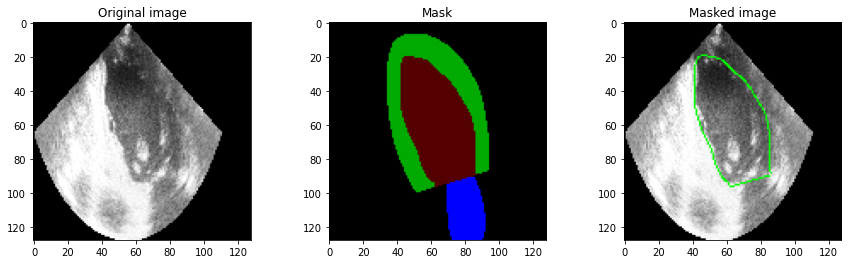

In [5]:
# display the last processed images
img1, img2 = image_resized, mask_channels_resized
img3 = cv2.cvtColor(img1, cv2.COLOR_GRAY2RGB)

edged = cv2.Canny(((img2 == 1)*255).astype(np.uint8), 30, 200) 
contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
cv2.drawContours(img3, contours, -1, (0, 255, 0), 1) 
  
plt.figure(figsize=(15, 4))
plt.subplot(1,3,1)
plt.title("Original image")
plt.imshow(img1, cmap='gray');
plt.subplot(1,3,2)
plt.title("Mask")
plt.imshow(img2 * 85, cmap='gray');
plt.subplot(1,3,3)
plt.title("Masked image")
plt.imshow(img3, cmap='gray');

## 2. Classes for handling the CamusDataset

The classes **CamusConfig** and **CamusDataset** extend mrcnn configuration classes to account for specificities of the Camus data set. 

In [6]:
class CamusConfig(Config):
    """
    Configuration for training on the Camus dataset.
    Derives from the base Config class and overrides values specific
    to the Camus dataset.
    """
    # Give the configuration a recognizable name
    NAME = "camus"

    # Train on 1 GPU and 4 images per GPU. Batch size is 4 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 heart structures

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because we have few objects (3) in the images 
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch (<100) or medium (<300)
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5

In [7]:
class CamusDataset(utils.Dataset):
    """
    Formats the Camus dataset. The dataset consists of frames of
    echocardiograms exams.
    """

    def load_camus(self, patients_path, height, width):
        """Loads an image from a file and adds to dataset."""
        # Add classes
        self.add_class("camus", 1, "ventricule")
        self.add_class("camus", 2, "muscle")
        self.add_class("camus", 3, "atrium")
    
        i = 0
        patients_dir = glob(patients_path)
        for patient_path in tqdm(patients_dir, ncols=80):
            filenames = glob(patient_path + "*_resized.png")
            for image_filename in filenames:
                if '_gt' in image_filename:
                    continue

                self.add_image("camus", image_id=i, path=image_filename,
                               width=width, height=height)
                i += 1

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID."""
        info = self.image_info[image_id]
        mask_image_path = info['path'].replace("_resized.png", "_gt_resized.png")
        mask = cv2.imread(mask_image_path)
        # If grayscale. Convert to RGB for consistency.
        if mask.ndim != 3:
            mask = skimage.color.gray2rgb(image)
        # If has an alpha channel, remove it for consistency
        if mask.shape[-1] == 4:
            mask = mask[..., :3]
        
        return mask, np.array([1, 2, 3])

    def __len__(self):
        """Return the number of read images"""
        return len(self.image_info)

In [8]:
config = CamusConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## 3. Training the model (transfer learning)

1. Split patients data set to train and validate the model
2. Train model on train set
3. Export weights to file

In [9]:
# Patients that have ids with endding in any digit but 1 are used to train the model
dataset_train = CamusDataset()
# dataset_train.load_camus("../../../../data/patient*[2,3,4,5,6,7,8,9,0]/", config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.load_camus("../../../../train/patient*[2,3,4,5,6,7,8,9,0]/", config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Patients that have ids with endding in 1 are used to validate/test the model
dataset_val = CamusDataset()
# dataset_val.load_camus("../../../../data/patient*[1]/", config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.load_camus("../../../../train/patient*[1]/", config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

str(len(dataset_train)) + " images loaded for training", str(len(dataset_val)) + " images loaded for validation"

100%|█████████████████████████████████████████| 35/35 [00:00<00:00, 2505.43it/s]


('1470 images loaded for training', '168 images loaded for validation')

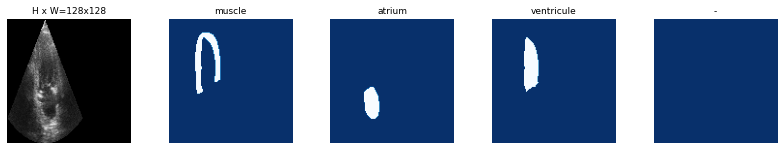

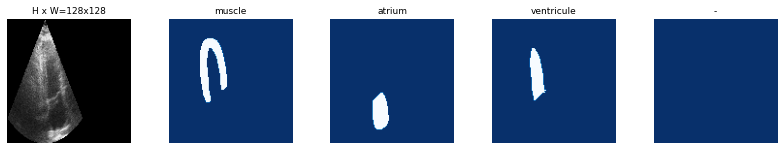

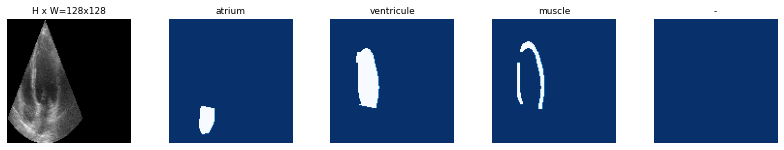

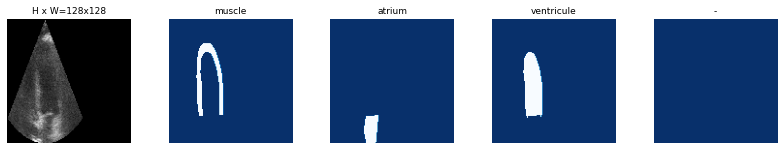

In [10]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [10]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [11]:
# Load weights trained on MS COCO, but skip layers that
# are different due to the different number of classes
# See README for instructions to download the COCO weights
model.load_weights(COCO_MODEL_PATH, by_name=True,
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                            "mrcnn_bbox", "mrcnn_mask"])

In [12]:
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')

In [13]:
# Save the trained model weights as a .h5 file
model_path = os.path.join(MODEL_DIR, "mask_rcnn_camus.h5")
model.keras_model.save_weights(model_path)

## 4. Inference - predicting atrium, ventricle and heart muscle in new echocardiogram studies

1. Configure the inference task
2. Load the weights for the trained model
3. Perform inference for new data and visualize results

In [13]:
class InferenceConfig(CamusConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Loading weights from  D:\AC Data\TaufferConsulting\Tauffer_fork\Mask_RCNN\logs\camus20200509T1447\mask_rcnn_camus_0001.h5
Re-starting from epoch 1


original_image           shape: (128, 128, 3)         min:    0.00000  max:  226.00000  uint8
image_meta               shape: (16,)                 min:    0.00000  max:  128.00000  int32
gt_class_id              shape: (3,)                  min:    1.00000  max:    3.00000  int32
gt_bbox                  shape: (3, 4)                min:   27.00000  max:  128.00000  int32
gt_mask                  shape: (128, 128, 3)         min:    0.00000  max:    3.00000  uint8


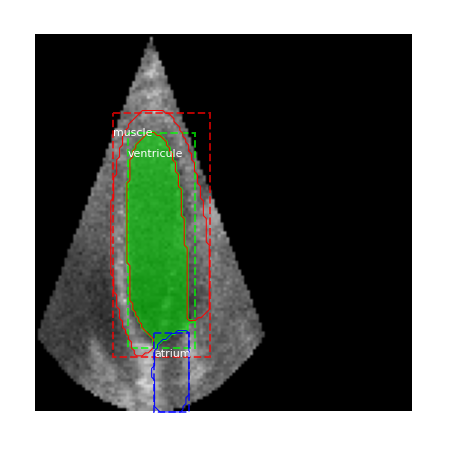

In [15]:
# Test on a random image from validation set
image_id = np.random.randint(0, len(dataset_val))
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  221.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:  117.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32


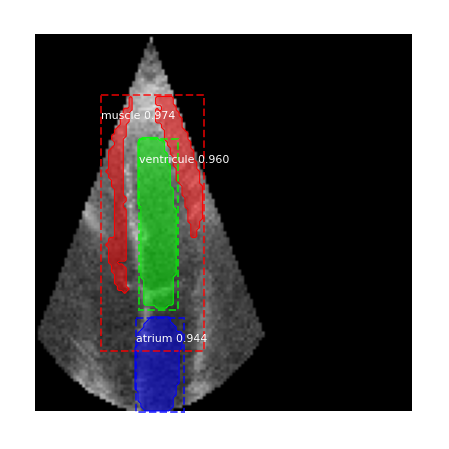

In [16]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  251.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:  147.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  224.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:  120.10000

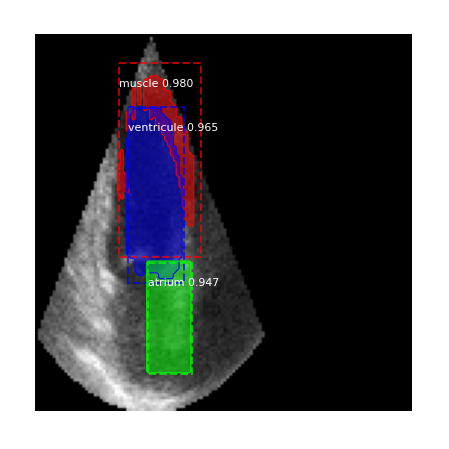

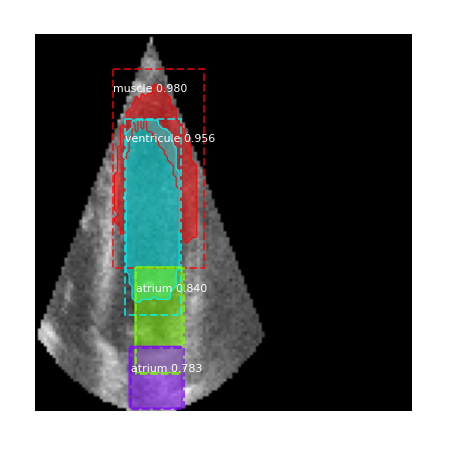

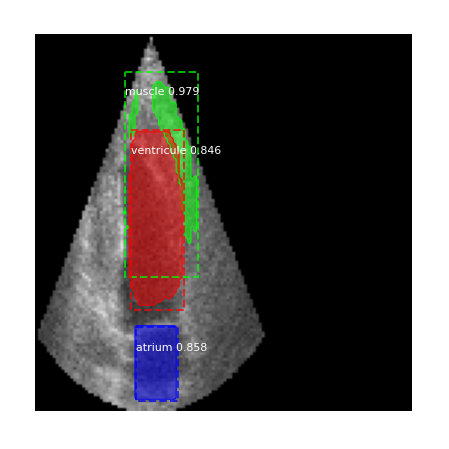

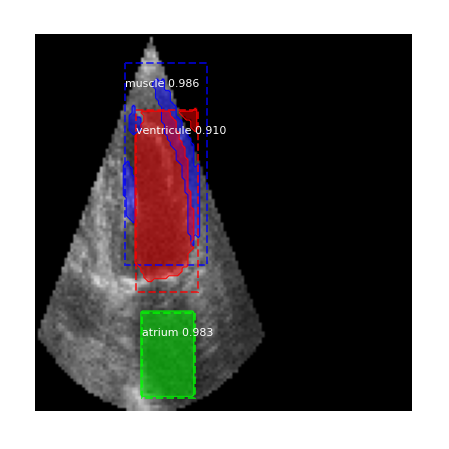

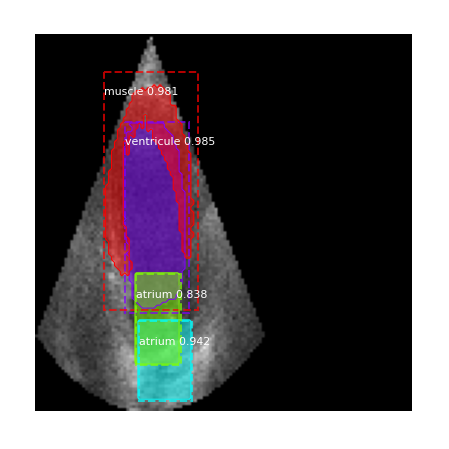

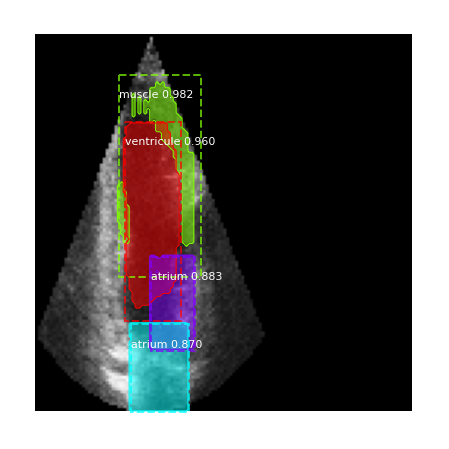

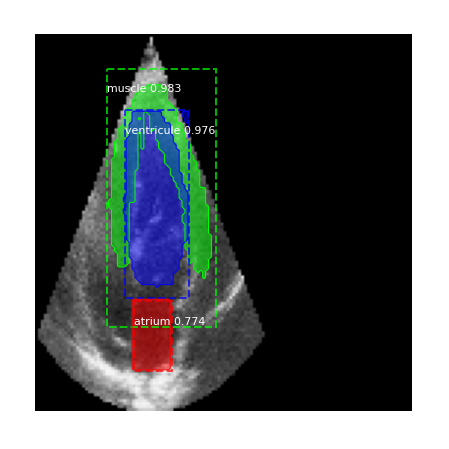

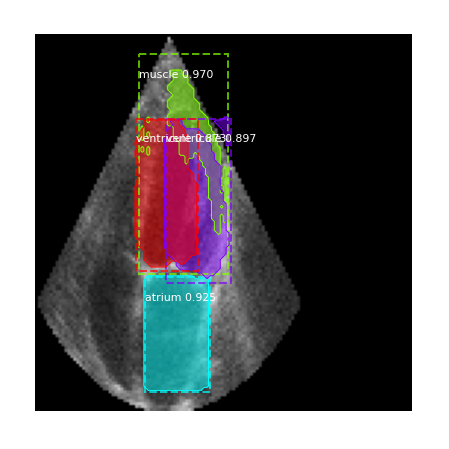

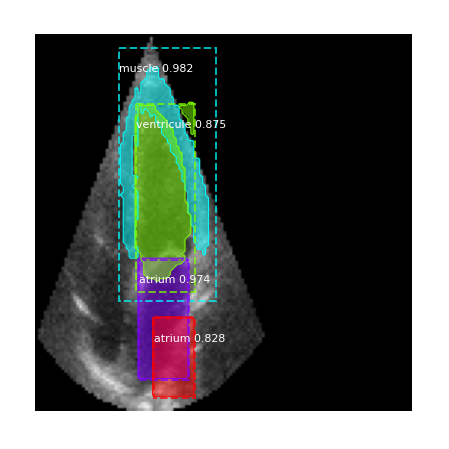

In [33]:
image_ids = np.random.randint(0, len(dataset_val), 9)
for id in image_ids:
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               id, use_mini_mask=False)

    results = model.detect([original_image], verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], ax=get_ax())